# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 2 - Classification with MLP



**Harvard University**<br/>
**Spring 2019**<br/>
**Instructors**: Mark Glickman and Pavlos Protopapas 


<hr style="height:2pt">

In [203]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.

- This homework can be submitted in pairs.

- If you submit individually but you have worked with someone, please include the name of your **one** partner below.
- Please restart the kernel and run the entire notebook again before you submit.

**Names of person you have worked with goes here:**
<br><BR>

###  Use only the libraries below:

In [204]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt 
from itertools import chain

from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import Callback, ModelCheckpoint, History, EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras import optimizers
from keras.utils import np_utils
from keras import optimizers
from keras.layers import Dropout
import keras.backend as K

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline

import seaborn as sns
sns.set()

%matplotlib inline

<div class="theme"> Overview </div> 

### Galaxy Zoo
For this homework you will work with real astronomical data with the purpose of classifying galaxies based on visual attributes as they appear in astronomical surveys of the night sky, such as color and morphology. Galaxy morphology is strongly correlated with many physical parameters of those astronomical bodies, including their mass, density distribution, temperature, and star formation history. In turn, these parameters can be estimated using observations of the attributes mentioned above. 

The Galaxy Zoo project includes collected morphological attributes of nearly 900,000 galaxies drawn from the [Sloan Digital Sky Survey](http://skyserver.sdss.org/dr15/en/home.aspx). The annotation was provided by hundreds of thousands of volunteers, or 'citizen scientists' as we call them, who voted on the galaxy type based only on its image (for more details on galaxy morphology and classification see <a href="https://academic.oup.com/mnras/article/410/1/166/1032478">Chris Lintott et al.</a>). 

Your task is to train a binary classifier on the Galaxy Zoo data in order to distinguish an elliptical galaxy from spirals, mergers and unknown, which we will call non-elliptical galaxies, based on its visual morphology.  

We provide a subset of data in `galaxy_morphology_labeled.csv` so there is no need for you to download it. The full dataset is available at http://data.galaxyzoo.org.


<span class='sub-q'> Dataset Attributes:</span>
- **green_color**: the amount of light measured in the green frequency band (wavelength range 464 $\pm$ 128~nm)
- **red_color**: the amount of light measured in the red frequency band (wavelength range 658 $\pm$ 138~nm)
- **infrared_color**: the amount of light measured in the infrared frequency band (wavelength range 806 $\pm$ 149~nm)
- **de_vaucouleurs_fit_axial_ratio**: axial ratio associated with the [de Vaucouleurs fit](https://en.wikipedia.org/wiki/De_Vaucouleurs%27_law) to the two-dimensional image of the galaxy
- **exponential_fit_axial_ratio**: the axial ratio associated with an exponential fit to the two-D image of the galaxy 
- **exponential_disc_fit_log_likelihood**: log likelihood associated with an exponential fit to the two-D image of the galaxy
- **de_vaucouleurs_fit_log_likelihood**: log likelihood associated with a de Vaucouleurs fit to the two-D image of the galaxy
- **star_log_likelihood**: the log likelihood that the object is a point-like source (star) object rather than a galaxy
- **number_of_votes**: total number of volunteer votes
- **probability_elliptical**: fraction of votes for elliptical morphology
- **probability_spiral**: fraction of votes for spiral morphology
- **probability_unknown**: fraction of votes for unknown morphology
- **probability_merger**: fraction of votes for merger morphology
- **class**: morphology with the highest fraction of votes

Notice that the volunteers did not have access to any of the attributes but the galaxy shape when voting.

<div class='exercise'><b> Question 1: Models for Galaxy Classification [30pts] </b></div>

<span class='sub-q'> **1.1** Understanding the Problem.</span> It is a good practice to start by familiarizing yourself with the problem in hand. Read the atricle by [Manda Banerji et al.](https://academic.oup.com/mnras/article/406/1/342/1073212) and familiarize yourself with the attributes in the dataset and their descriptions. Based on your reading, which attributes in the data are most predictive of whether or not a galaxy is elliptical?


<span class='sub-q'> 1.2 Performing Data Exploration and Cleaning.</span> 



- **1.2.1** The color bands sometimes include values that are far away from the rest, what we call outliers. Outlier values might indicate bad measurements for example instrumental failures. Remove the data points with these values in the color band of your choice. 
- **1.2.2** Are the features sufficiently distinguishing for the classification task? Do elliptical galaxies differ enough in terms of these attributes from other types of objects in the sky? 

**Hint:** compare the distributions of features for elliptical galaxies with the feature distributions of other objects in the data set.

<span class='sub-q'> 1.3 Feature Engineering. </span> The practice of creating new features by combining observed features in the data using domain knowledge is called *feature engineering*. Astronomers often use differences in color bands as an engineered feature that serves as a proxy to temperature. Create two new features in the data that represent temperature. Do these two new features help distinguish elliptical galaxies from other objects, i.e., are these two new features useful for the classification task?

<span class='sub-q'> 1.4 Training a Baseline Classifier. </span> Using `keras`, construct and train a MLP classifier to classify galaxies as either elliptical or non-elliptical based on your expanded set of features. 

For the network you want to consider:
- the number of hidden layers
- the number of nodes in each hidden layer
- the activation function (we suggest starting with `relu`)
- the choice of a loss function
- the choice of mini-batch size (we suggest between 1000 and 5000)
- the choice of an optimizer and its parameters, for example: `learning rate`, `momentum`, and `learning rate decay`
- the number of epochs

**Hint:** You can expect to achieve an average classification accuracy of >80% with the appropriate choices.

<span class='sub-q'>1.5 Evaluating and Improving Your Classifier. </span> Choose an appropriate metric for evaluating your classifier. Is the average classification accuracy a good metric for this data given the distribution of the classes? Improve your classifier based on the distribution of the classes and on your evaluation of the baseline classifier. 

**Hint:** You can expect to achieve an average classification accuracy of >90% with this.

In [205]:
galaxy_df = pd.read_csv('data/galaxy_morphology_labeled.csv')
galaxy_df.head()

,green_color,red_color,infrared_color,de_vaucouleurs_fit_axial_ratio,exponential_fit_axial_ratio,exponential_disc_fit_log_likelihood,de_vaucouleurs_fit_log_likelihood,star_log_likelihood,number_of_votes,probability_elliptical,probability_spiral,probability_unknown,probability_merger,class
0,17.952690,17.077210,16.696932,0.652044,0.674899,-299.83917,-147.78073,-2480.1614,30,0.033,0.933,0.033,0.000,spiral
1,15.870294,15.128039,14.746254,0.661844,0.631145,-4980.44200,-2094.24630,-41855.1640,58,0.000,1.000,0.000,0.000,spiral
2,16.473410,15.633129,15.174894,0.324888,0.356353,-3732.98900,-946.47595,-26244.6110,43,0.186,0.744,0.070,0.000,spiral
3,17.137112,16.744455,16.542747,0.582045,0.656639,-33.33683,-587.22380,-4487.7620,63,0.143,0.810,0.048,0.000,spiral
4,17.995703,17.621641,17.377476,0.449918,0.462352,-26.84463,-130.57242,-2392.1540,42,0.167,0.738,0.071,0.024,spiral


# SOLUTION 1.1

**STUDENT COMMENTARY:**

- The article states that the early types (i.e., ellipticals and lenticular systems) are usually redder than spirals.  Point sources and artefacts, unfortunately, exhibit a wider range of colors that presumably includes red.
- The article states that the axial ratio for early types are larger than for spirals.  Again, point sources and artefacts cannot be distinquished from early types so easily.
- Combinging these traditional color and profile-fitting parameters leads to 87% correct classification of early types.
- The article refers to differences among other attributes that we are not considering (i.e., conentration, adaptive shape and texture parameters). 

# SOLUTION 1.2.1

### Create train/test split before doing any work with the data

In [206]:
# Check for na values
r0 = galaxy_df.shape[1]
r1 = galaxy_df.dropna().shape[1]
print(f"The dataset appears to have {r0-r1} rows with NA values in a column.")

# Lets define binary classification for full dataset
galaxy_df["binary_class"] = galaxy_df["class"].apply(lambda x: 1 if x == "elliptical" else 0)

# Split source data into train/test
train, test = train_test_split(galaxy_df, test_size=.3, random_state=42)

The dataset appears to have 0 rows with NA values in a column.


### Remove Green Outliers

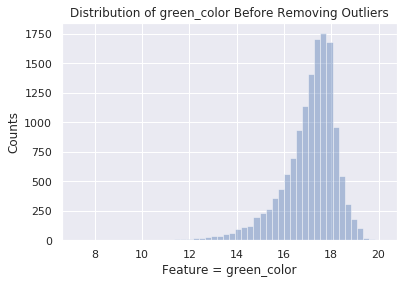

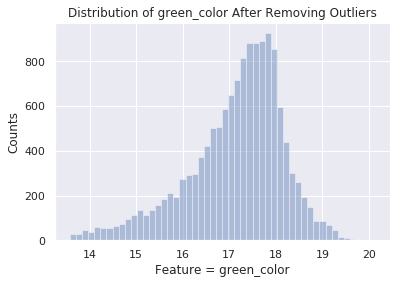

In [207]:
# Show distribution of green_color before removing outliers
feature = "green_color"
x0 = train[feature].values

# Plot histogram
fig, ax = plt.subplots()

sns.distplot(x0, kde=False, ax=ax)
plt.xlabel(str(f"Feature = {feature}"))
plt.ylabel("Counts")
plt.title(f"Distribution of {feature} Before Removing Outliers")

# Define dictionary to contain mean, std and +/- 3*std
# key = feature string name
# value = tuple (mean, std, mean-3sd, mean+3sd)
feature_stats = dict()

# Define key of dictionary
feature= "green_color"

# Add lower bound and upper bounds to dictionary for feature
feature_stats[feature] = (train[feature].mean(),
                          train[feature].std(),
                          train[feature].mean()-3*train[feature].std(),
                          train[feature].mean()+3*train[feature].std())

# Keep only rows within range
# Perform same cleaning to test as train (with train's lb/ub)
mu, sig, lb, ub = feature_stats.get(feature)
train = train.loc[(train[feature] > lb) & \
                  (train[feature] < ub),]
test = test.loc[(test[feature] > lb) & \
                (test[feature] < ub),]


# Show distribution of green_color after removing outliers
for feature in ["green_color"]:
    x = train[feature]
    
    # Plot histogram
    fig, ax = plt.subplots()
    sns.distplot(x, kde=False)
    plt.xlabel(f"Feature = {feature}")
    plt.ylabel("Counts")
    plt.title(f"Distribution of {feature} After Removing Outliers")

# SOLUTION 1.2.2

### Show Distribution of Features - Class by Class (after removing only green_color outliers)

In [208]:
# Specify features on which to classify (excluding label related columns)
orig_features = [col for col in train.columns \
                 if col not in ["number_of_votes",
                                "probability_elliptical",
                                "probability_spiral",
                                "probability_unknown",
                                "probability_merger",
                                "class", 
                                "binary_class"]]                           

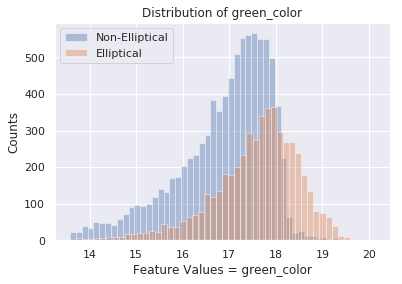

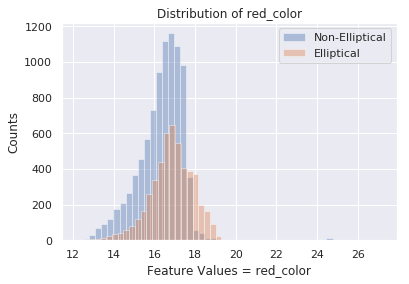

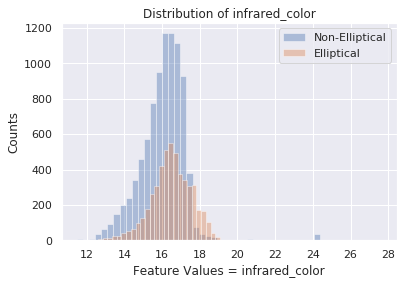

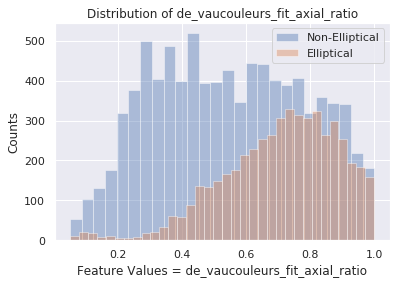

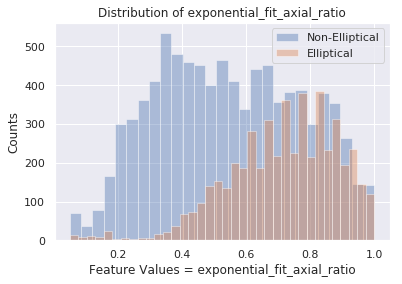

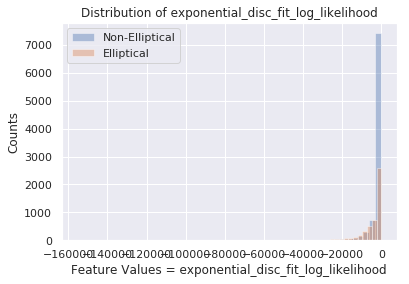

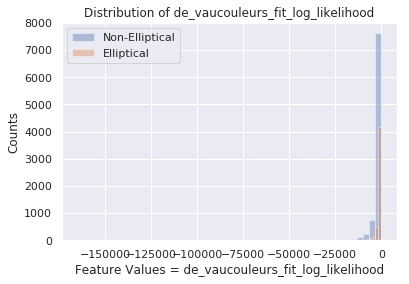

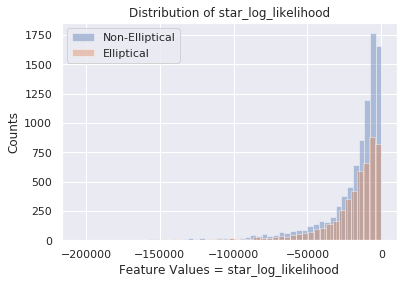

In [209]:
# Show distribution of values for each feature class 0 vs. class 1
for feature in orig_features:
    x0 = train.loc[train["binary_class"] == 0, \
                   feature].values
    x1 = train.loc[train["binary_class"] == 1, \
                   feature].values

    # Plot histogram
    fig, ax = plt.subplots()
    sns.distplot(x0, label = "Non-Elliptical", kde=False, ax=ax)
    sns.distplot(x1, label = "Elliptical", kde=False, ax=ax)
    plt.xlabel(f"Feature Values = {feature}")
    plt.ylabel("Counts")
    plt.title(f"Distribution of {feature}")
    plt.legend()

**STUDENT COMMENTARY:**

- Mark & Saurabh to discuss
- Mark & Saurabh to discuss
- Mark & Saurabh to discuss

# SOLUTION 1.3

In [210]:
# Remove more outliers?

In [211]:
# Engineer new feature for green-red
# Engineer new feature for green-infrared
# Perform same engineering to test as train
train["g_r_diff"] = train["green_color"]-train["red_color"]
train["r_i_diff"] = train["red_color"]-train["infrared_color"]
test["g_r_diff"] = test["green_color"]-test["red_color"]
test["r_i_diff"] = test["red_color"]-test["infrared_color"]

# Define engineered feature list
eng_features = ["g_r_diff", "r_i_diff"]

In [212]:
train.head()

,green_color,red_color,infrared_color,de_vaucouleurs_fit_axial_ratio,exponential_fit_axial_ratio,exponential_disc_fit_log_likelihood,de_vaucouleurs_fit_log_likelihood,star_log_likelihood,number_of_votes,probability_elliptical,probability_spiral,probability_unknown,probability_merger,class,binary_class,g_r_diff,r_i_diff
11840,15.644774,14.717614,14.294826,0.698340,0.666152,-36779.07000,-1132.71561,-90810.1700,66,0.970,0.015,0.015,0.000,elliptical,1,0.927160,0.422788
19213,16.034718,15.710101,15.637711,0.106681,0.097844,-444.75232,-937.97986,-3662.0017,47,0.277,0.043,0.681,0.000,unknown,0,0.324617,0.072390
2525,16.727797,16.225294,16.131588,0.914987,0.961284,-447.90890,-1004.38700,-7703.3950,31,0.032,0.935,0.000,0.032,spiral,0,0.502503,0.093706
1684,17.679327,16.940964,16.586640,0.265166,0.310495,-55.12116,-454.34320,-9026.1440,64,0.391,0.578,0.031,0.000,spiral,0,0.738363,0.354324
9380,15.282916,14.805243,14.606499,0.924899,0.738755,-75.80847,-2233.94820,-13573.0950,58,0.052,0.879,0.069,0.000,spiral,0,0.477673,0.198745


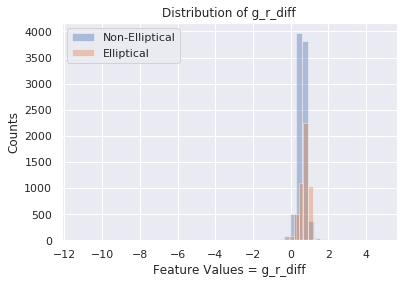

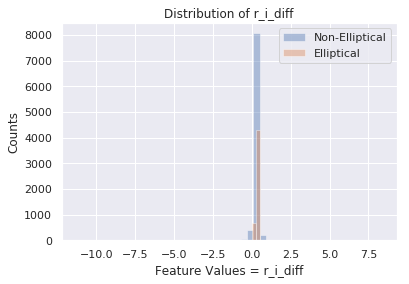

In [213]:
# Show distribution of values for engineered features class 0 vs. class 1
for feature in eng_features:
    x0 = train.loc[train["binary_class"] == 0, \
                   feature].values
    x1 = train.loc[train["binary_class"] == 1, \
                   feature].values

    # Plot histogram
    fig, ax = plt.subplots()
    sns.distplot(x0, label = "Non-Elliptical", kde=False, ax=ax)
    sns.distplot(x1, label = "Elliptical", kde=False, ax=ax)
    plt.xlabel(str(f"Feature Values = {feature}"))
    plt.ylabel("Counts")
    plt.title(f"Distribution of {feature}")
    plt.legend()

**STUDENT COMMENTARY:**

- Mark & Saurabh to discuss
- Mark & Saurabh to discuss
- Mark & Saurabh to discuss

# SOLUTION 1.4

### Create X and Y vectors appropriate for Keras

In [214]:
# Define x & y for train and test
x_train = train[orig_features+eng_features]
y_train = train["binary_class"]
x_test = test[orig_features+eng_features]
y_test = test["binary_class"]

In [215]:
# Convert x into scaled numpy array
scaler = StandardScaler().fit(x_train.astype(np.float64))
x_train_scaled = scaler.transform(x_train.astype(np.float64))
x_test_scaled = scaler.transform(x_test.astype(np.float64))

# Convert y into categorial for Keras
y_train_cat = np_utils.to_categorical(y_train)
y_test_cat = np_utils.to_categorical(y_test)

### Build/run initial NN

In [191]:
# Defining hyperparameters
batch_size = 512*2*2*2
epochs=5
learning_rate = .01
decay = 0.005
momentum = 0.01

In [15]:
# build the model
input_dim = x_train_scaled.shape[1]

model = Sequential()
model.add(Dense(40, activation="relu", kernel_initializer="normal", input_dim = input_dim))
model.add(Dense(30, activation="relu", kernel_initializer="normal"))
model.add(Dense(25, activation="relu", kernel_initializer="normal"))
model.add(Dense(20, activation="relu", kernel_initializer="normal"))
model.add(Dense(15, activation="relu", kernel_initializer="normal"))
model.add(Dense(10, activation="relu", kernel_initializer="normal"))
model.add(Dense(5, activation="relu", kernel_initializer="normal"))
model.add(Dropout(0.2))
model.add(Dense(units=2, kernel_initializer="normal", activation="sigmoid"))
print(model.summary())


# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=learning_rate,
                                        beta_1=.9,
                                        beta_2=.999,
                                        decay=decay,
                                        amsgrad=False),
              metrics=["accuracy"])

"""

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=learning_rate, 
                                       decay=decay,
                                       nesterov=True), 
              metrics=["accuracy"]) #, specificity, sensitivity])


"""

# Set callbacks to early stop and save best model
callbacks = [EarlyStopping(monitor="val_acc", patience=20),
             ModelCheckpoint(filepath="data/best_model", 
                             monitor="val_acc", 
                             save_best_only=True)]

# Fit the model
model_history = model.fit(x_train_scaled, y_train_cat,
                          batch_size=batch_size,
                          epochs=epochs,
                          callbacks=callbacks,
                          verbose=1,
                          validation_data=(x_test_scaled, y_test_cat))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 40)                440       
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1230      
_________________________________________________________________
dense_3 (Dense)              (None, 25)                775       
_________________________________________________________________
dense_4 (Dense)              (None, 20)                520       
_________________________________________________________________
dense_5 (Dense)              (None, 15)                315       
_________________________________________________________________
dense_6 (Dense)              (None, 10)                160       
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 55        
__________

Test Loss = 0.663157902586766.
Test Accuracy = 0.6315612946803311.


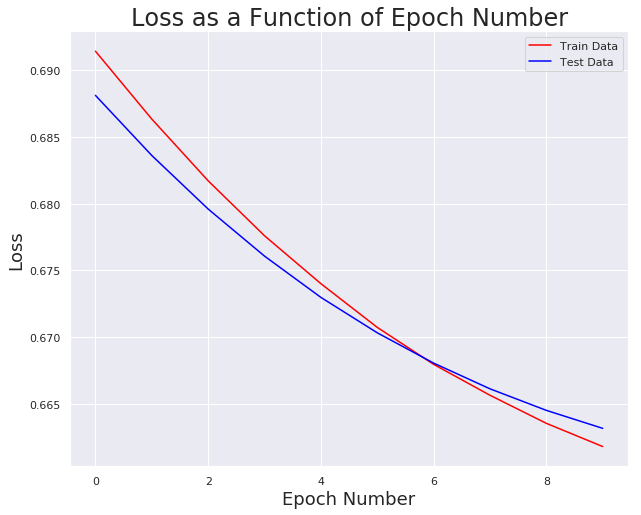

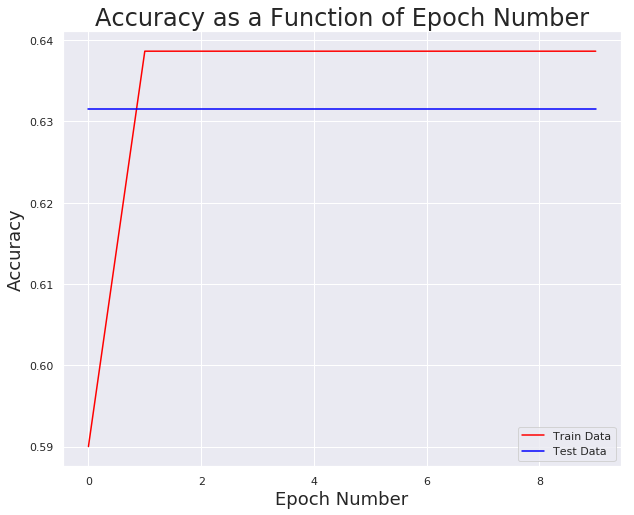

In [16]:
# Plot loss training vs. test
fig, ax = plt.subplots(1,1, figsize = (10,8))
ax.plot(model_history.history["loss"], "red", label="Train Data")
ax.plot(model_history.history["val_loss"], "blue", label="Test Data")
ax.set_xlabel("Epoch Number", fontsize = 18)
ax.set_ylabel("Loss", fontsize = 18)
ax.set_title("Loss as a Function of Epoch Number", fontsize=24)
ax.tick_params()
ax.legend()

# Plot accuracy training vs. test
fig, ax = plt.subplots(1,1, figsize = (10,8))
ax.plot(model_history.history["acc"], "red", label="Train Data")
ax.plot(model_history.history["val_acc"], "blue", label="Test Data")
ax.set_xlabel("Epoch Number", fontsize = 18)
ax.set_ylabel("Accuracy", fontsize = 18)
ax.set_title("Accuracy as a Function of Epoch Number", fontsize=24)
ax.tick_params()
ax.legend()

# Just for completeness, print final scores
score = model.evaluate(x_test_scaled, y_test_cat, verbose=0)
print(f"Test Loss = {score[0]}.")
print(f"Test Accuracy = {score[1]}.")

# SOLUTION 1.5

**STUDENT COMMENTARY:**

We use code from this website to implement custom metrics using keras.backend:  http://www.deepideas.net/unbalanced-classes-machine-learning/

In [17]:
# Define two custom metrics
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [18]:
# Define ratio of of non-ellip to ellip
# Use this ratio to give more weight in loss function
# to the underweighted (elliptical) class
count_elliptical = train[train["binary_class"]==1].green_color.count()
count_non_elliptical = train[train["binary_class"]==0].green_color.count()
re_weight_ratio = count_non_elliptical / count_elliptical

# Create sample_weight array to tell loss function to give more penalty for ellipticals
sample_weight = train["binary_class"].apply(lambda x: 1 if x == 0 else re_weight_ratio).values

# Re-compile the model
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=learning_rate,
                                        beta_1=.9,
                                        beta_2=.999,
                                        decay=decay,
                                        amsgrad=False),
              metrics=["accuracy", specificity, sensitivity])

# Re-set callbacks to early stop and save best model
callbacks = [EarlyStopping(monitor="val_loss", patience=10),
             ModelCheckpoint(filepath="best_model", 
                             monitor="val_loss", 
                             save_best_only=True)]

# Re-fit the model with sample weightings
model_history = model.fit(x_train_scaled, y_train_cat,
                          batch_size=batch_size,
                          epochs=epochs,
                          callbacks=callbacks,
                          verbose=0,
                          sample_weight=sample_weight,
                          validation_data=(x_test_scaled, y_test_cat))

Test Loss = 0.688657270258712.
Test Accuracy = 0.6315612946803311.
Test Specificity = 0.6315612946803311.
Test Sensitivity = 0.6315612946803311.


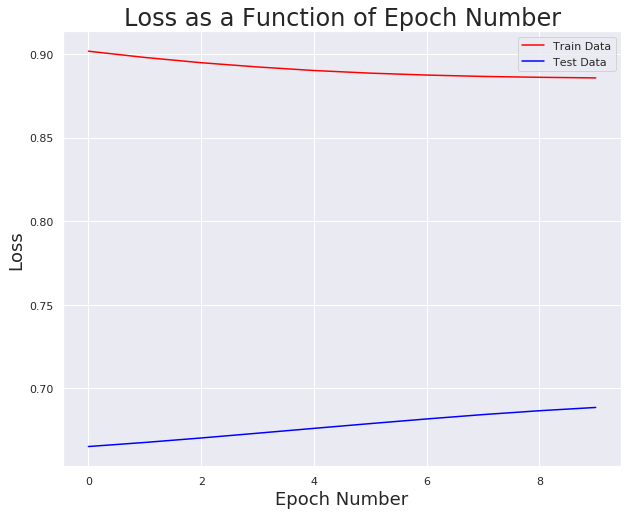

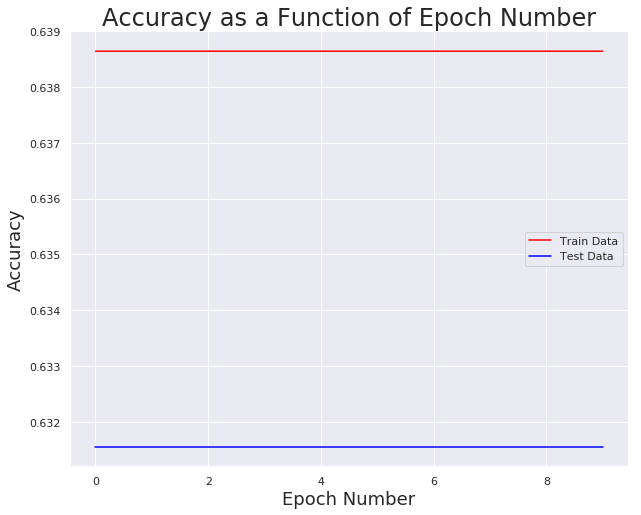

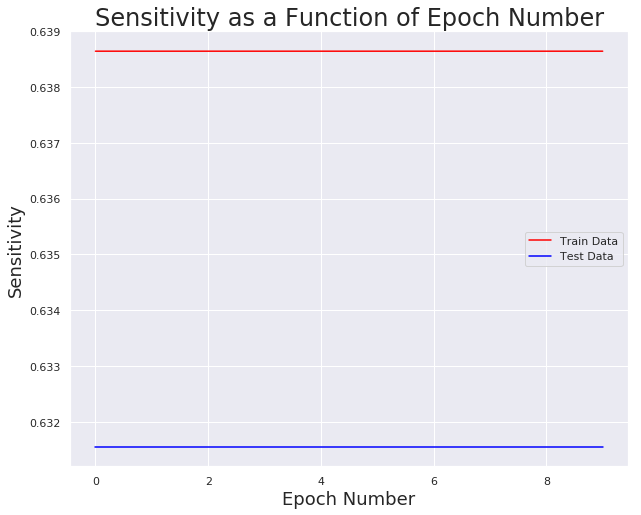

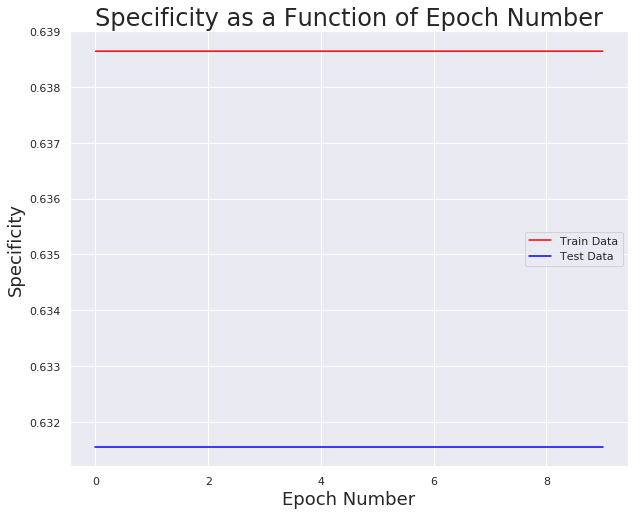

In [19]:
# Plot loss training vs. test
fig, ax = plt.subplots(1,1, figsize = (10,8))
ax.plot(model_history.history["loss"], "red", label="Train Data")
ax.plot(model_history.history["val_loss"], "blue", label="Test Data")
ax.set_xlabel("Epoch Number", fontsize = 18)
ax.set_ylabel("Loss", fontsize = 18)
ax.set_title("Loss as a Function of Epoch Number", fontsize=24)
ax.tick_params()
ax.legend()

# Plot accuracy training vs. test
fig, ax = plt.subplots(1,1, figsize = (10,8))
ax.plot(model_history.history["acc"], "red", label="Train Data")
ax.plot(model_history.history["val_acc"], "blue", label="Test Data")
ax.set_xlabel("Epoch Number", fontsize = 18)
ax.set_ylabel("Accuracy", fontsize = 18)
ax.set_title("Accuracy as a Function of Epoch Number", fontsize=24)
ax.tick_params()
ax.legend()

# Plot specificity training vs. test
fig, ax = plt.subplots(1,1, figsize = (10,8))
ax.plot(model_history.history["sensitivity"], "red", label="Train Data")
ax.plot(model_history.history["val_sensitivity"], "blue", label="Test Data")
ax.set_xlabel("Epoch Number", fontsize = 18)
ax.set_ylabel("Sensitivity", fontsize = 18)
ax.set_title("Sensitivity as a Function of Epoch Number", fontsize=24)
ax.tick_params()
ax.legend()

# Plot sensitivity training vs. test
fig, ax = plt.subplots(1,1, figsize = (10,8))
ax.plot(model_history.history["specificity"], "red", label="Train Data")
ax.plot(model_history.history["val_specificity"], "blue", label="Test Data")
ax.set_xlabel("Epoch Number", fontsize = 18)
ax.set_ylabel("Specificity", fontsize = 18)
ax.set_title("Specificity as a Function of Epoch Number", fontsize=24)
ax.tick_params()
ax.legend()

# Just for completeness, print final scores
score = model.evaluate(x_test_scaled, y_test_cat, verbose=0)
print(f"Test Loss = {score[0]}.")
print(f"Test Accuracy = {score[1]}.")
print(f"Test Specificity = {score[2]}.")
print(f"Test Sensitivity = {score[3]}.")

<div class='exercise'><b> Question 2: Optimization Problems in Model Training </b></div>

In Question 1, you found an appropriate choice of training parameters for your model (e.g. optimizer, learning rate etc). In this problem, you will carefully investigate the effect of these parameters on the baseline model from Question 1.

<span class='sub-q'> 2.1 </span> Using the Adam optimizer, plot the loss function as well as the average classification accuracy [PP: training accuracies] for each of the following learning rates `[1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4]`. Compare these graphs and make an argument for which of these learning rates is more appropriate for our data set.

<span class='sub-q'> 2.2 </span> Using the SGD optimizer, plot the loss function as well as the average classification accuracy for each of the following learning rates `[1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4]`. Compare these graphs and make an argument for which of these learning rates is more appropriate for our data set. For the optimal learning rate, experiment with a range of values for momentum, `[9e-1, 8e-1, 7e-1, 6e-1, 5e-1, 4e-1]` with a learning rate decay of `optimal_rate / total_epochs`. Make an argument for which value of momentum is more appropriate for our data set.

<span class='sub-q'> 2.3 </span> Compare model training using Adam versus SGD:
- describe the difference between the behaviors of these two optimizers. 
- which optimizer gives the best model at the end of say 5000 epochs?

Which optimization method do you prefer for this data set? Why? 
Think of some scenarios where each optimizer might be more appropriate than the other.

Other parameters for optimization include more complex decay rates, you can [read more](https://medium.com/octavian-ai/which-optimizer-and-learning-rate-should-i-use-for-deep-learning-5acb418f9b2) about how these choices affect training.

# Use pipelines?

# SOLUTION 2.1

In [200]:
# let's create a function that creates the model
def build_nn_model(learning_rate):
    # define model
    model = Sequential()
    model.add(Dense(40, activation="relu", kernel_initializer="normal", input_dim = input_dim))
    model.add(Dense(30, activation="relu", kernel_initializer="normal"))
    model.add(Dense(25, activation="relu", kernel_initializer="normal"))
    model.add(Dense(20, activation="relu", kernel_initializer="normal"))
    model.add(Dense(15, activation="relu", kernel_initializer="normal"))
    model.add(Dense(10, activation="relu", kernel_initializer="normal"))
    model.add(Dense(5, activation="relu", kernel_initializer="normal"))
    model.add(Dropout(0.2))
    model.add(Dense(units=2, kernel_initializer="normal", activation="sigmoid"))
    
    # Compile the model
    model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=learning_rate,
                                        beta_1=.9,
                                        beta_2=.999,
                                        decay=decay,
                                        amsgrad=False),
              metrics=["accuracy"])
    
    return model


'''
# Convert x into scaled numpy array
scaler = StandardScaler().fit(x_train.astype(np.float64))
x_train_scaled = scaler.transform(x_train.astype(np.float64))
x_test_scaled = scaler.transform(x_test.astype(np.float64))

# Convert y into categorial for Keras
y_train_cat = np_utils.to_categorical(y_train)
y_test_cat = np_utils.to_categorical(y_test)
'''

# Set callbacks to early stop and save best model
callbacks = [EarlyStopping(monitor="val_acc", patience=20),
             ModelCheckpoint(filepath="data/best_model", 
                             monitor="val_acc", 
                             save_best_only=True)]

estimator = KerasClassifier(build_fn=build_nn_model,
                            epochs=epochs, 
                            batch_size=batch_size, 
                            verbose=1)

pipeline = Pipeline([("std_scale", StandardScaler()),
                     ("keras_nn", estimator)])

param_grid = [{"keras_nn__learning_rate": [.1],
               "keras_nn__callbacks": [callbacks]}]


"""
, #[10, 1, .1, .01, .001, .0001]},
              {"keras_nn__sample_weight": sample_weight},
              {"keras_nn__callbacks": callbacks}]
"""

grid = GridSearchCV(estimator=pipeline, 
                    param_grid=param_grid, 
                    cv=4)

# How am I controlling what StandardScaler is scaling?  All columns in x_train?  y_train_cat?
# I also just need to do regular fit with selected hyper parameter and measure using test/validation data

In [201]:
grid

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('std_scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('keras_nn', <keras.wrappers.scikit_learn.KerasClassifier object at 0x7faaa6b93c18>)]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'keras_nn__learning_rate': [0.1], 'keras_nn__callbacks': [[<keras.callbacks.EarlyStopping object at 0x7faaa6943518>, <keras.callbacks.ModelCheckpoint object at 0x7faaa6943550>]]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [202]:
grid_result = grid.fit(X=x_train, y=y_train_cat)

Epoch 1/5
10427/10427 [==============================] - 14s 1ms/step - loss: 0.6826 - acc: 0.5783
Epoch 2/5
10427/10427 [==============================] - 0s 5us/step - loss: 0.6515 - acc: 0.6358
Epoch 3/5
10427/10427 [==============================] - 0s 5us/step - loss: 0.6312 - acc: 0.6358
Epoch 4/5
10427/10427 [==============================] - 0s 5us/step - loss: 0.5617 - acc: 0.6358
Epoch 5/5
 4096/10427 [==========>...................] - ETA: 0s - loss: 0.5355 - acc: 0.6389

/home/mjcarleb/anaconda3/envs/dasktut/lib/python3.6/site-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/mjcarleb/anaconda3/envs/dasktut/lib/python3.6/site-packages/keras/callbacks.py:434: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


10427/10427 [==============================] - 0s 5us/step
Epoch 1/5
10427/10427 [==============================] - 14s 1ms/step - loss: 0.6816 - acc: 0.5877
Epoch 2/5
10427/10427 [==============================] - 0s 5us/step - loss: 0.6405 - acc: 0.6416
Epoch 3/5
10427/10427 [==============================] - 0s 6us/step - loss: 0.6402 - acc: 0.6416
Epoch 4/5
 4096/10427 [==========>...................] - ETA: 0s - loss: 0.6223 - acc: 0.6440

/home/mjcarleb/anaconda3/envs/dasktut/lib/python3.6/site-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/mjcarleb/anaconda3/envs/dasktut/lib/python3.6/site-packages/keras/callbacks.py:434: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


10427/10427 [==============================] - 0s 8us/step - loss: 0.6163 - acc: 0.6416
Epoch 5/5
10427/10427 [==============================] - 0s 3us/step
Epoch 1/5
10427/10427 [==============================] - 14s 1ms/step - loss: 0.6809 - acc: 0.6150
Epoch 2/5
10427/10427 [==============================] - 0s 6us/step - loss: 0.6462 - acc: 0.6382
Epoch 3/5
10427/10427 [==============================] - 0s 6us/step - loss: 0.6251 - acc: 0.6382
Epoch 4/5
 4096/10427 [==========>...................] - ETA: 0s - loss: 0.6162 - acc: 0.6387

/home/mjcarleb/anaconda3/envs/dasktut/lib/python3.6/site-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/mjcarleb/anaconda3/envs/dasktut/lib/python3.6/site-packages/keras/callbacks.py:434: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


10427/10427 [==============================] - 0s 10us/step - loss: 0.5851 - acc: 0.6383
Epoch 5/5
10427/10427 [==============================] - 0s 4us/step
Epoch 1/5
10428/10428 [==============================] - 14s 1ms/step - loss: 0.6813 - acc: 0.5842
Epoch 2/5
10428/10428 [==============================] - 0s 6us/step - loss: 0.6148 - acc: 0.6389
Epoch 3/5
10428/10428 [==============================] - 0s 7us/step - loss: 0.6598 - acc: 0.6389
Epoch 4/5
10428/10428 [==============================] - 0s 6us/step - loss: 0.6577 - acc: 0.6389
Epoch 5/5


/home/mjcarleb/anaconda3/envs/dasktut/lib/python3.6/site-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/mjcarleb/anaconda3/envs/dasktut/lib/python3.6/site-packages/keras/callbacks.py:434: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


10428/10428 [==============================] - 0s 5us/step
Epoch 1/5
13903/13903 [==============================] - 14s 1ms/step - loss: 0.6715 - acc: 0.6038
Epoch 2/5
13903/13903 [==============================] - 0s 5us/step - loss: 0.6565 - acc: 0.6386
Epoch 3/5
13903/13903 [==============================] - 0s 6us/step - loss: 0.6562 - acc: 0.6386
Epoch 4/5
 4096/13903 [=======>......................] - ETA: 0s - loss: 0.6554 - acc: 0.6367

/home/mjcarleb/anaconda3/envs/dasktut/lib/python3.6/site-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/mjcarleb/anaconda3/envs/dasktut/lib/python3.6/site-packages/keras/callbacks.py:434: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


13903/13903 [==============================] - 0s 4us/step - loss: 0.6543 - acc: 0.6386
Epoch 5/5
13903/13903 [==============================] - 0s 6us/step - loss: 0.6547 - acc: 0.6386


In [195]:
grid_result

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('std_scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('keras_nn', <keras.wrappers.scikit_learn.KerasClassifier object at 0x7faaababcb00>)]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'keras_nn__learning_rate': [0.1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [196]:
# print results
print(f'Best Accuracy was {grid_result.best_score_} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')

Best Accuracy was 0.6641372418666001 using {'keras_nn__learning_rate': 0.1}
 mean=0.6641, std=0.04422 using {'keras_nn__learning_rate': 0.1}


# SOLUTION 2.2

## SGD:  Cross-Validate Learning Rate

In [ ]:
# let's create a function that creates the model
def build_nn_model(learning_rate):
    # define model
    model = Sequential()
    model.add(Dense(40, activation="relu", kernel_initializer="normal", input_dim = input_dim))
    model.add(Dense(30, activation="relu", kernel_initializer="normal"))
    model.add(Dense(25, activation="relu", kernel_initializer="normal"))
    model.add(Dense(20, activation="relu", kernel_initializer="normal"))
    model.add(Dense(15, activation="relu", kernel_initializer="normal"))
    model.add(Dense(10, activation="relu", kernel_initializer="normal"))
    model.add(Dense(5, activation="relu", kernel_initializer="normal"))
    model.add(Dropout(0.2))
    model.add(Dense(units=2, kernel_initializer="normal", activation="sigmoid"))
    
    # Compile the model
    model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=learning_rate, 
                                       decay=decay,
                                       nesterov=False), 
              metrics=["accuracy", specificity, sensitivity])
    
    return model

# Set the model and parameters for GridSearchCV 
estimator = KerasClassifier(build_fn=build_nn_model, 
                            epochs=epochs, 
                            batch_size=batch_size, 
                            verbose=0)

param_grid = [{"learning_rate": [10, 1, .1, .01, .001, .0001]}]

# Define the GridSearchCV to find the best set of parameters
grid = GridSearchCV(estimator=estimator, 
                    param_grid=param_grid, 
                    cv=3)

# Fit the model using GridSearchCV on on training data
grid_result = grid.fit(x_train_scaled, y_train_cat, 
                       callbacks=callbacks,
                       sample_weight=sample_weight,
                       validation_data=(x_test_scaled, y_test_cat))

In [ ]:
# print results
print(f'Best Accuracy was {grid_result.best_score_} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
best_mean = 0
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')
    if mean>best_mean:
        best_mean = mean
        best_lr = param.get("learning_rate")

## SGD:  Cross-Validate Momentum with Optimal Learning Rate

In [ ]:
# let's create a function that creates the model
def build_nn_model(momentum):
    # define model
    model = Sequential()
    model.add(Dense(40, activation="relu", kernel_initializer="normal", input_dim = input_dim))
    model.add(Dense(30, activation="relu", kernel_initializer="normal"))
    model.add(Dense(25, activation="relu", kernel_initializer="normal"))
    model.add(Dense(20, activation="relu", kernel_initializer="normal"))
    model.add(Dense(15, activation="relu", kernel_initializer="normal"))
    model.add(Dense(10, activation="relu", kernel_initializer="normal"))
    model.add(Dense(5, activation="relu", kernel_initializer="normal"))
    model.add(Dropout(0.2))
    model.add(Dense(units=2, kernel_initializer="normal", activation="sigmoid"))
 
    # Compile the model
    model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=best_lr, 
                                       decay=decay,
                                       momentum=momentum,
                                       nesterov=False), 
              metrics=["accuracy"])
    
    return model

# Set the model and parameters for GridSearchCV 
estimator = KerasClassifier(build_fn=build_nn_model, 
                            epochs=epochs, 
                            batch_size=batch_size, 
                            verbose=0)

param_grid = [{"momentum": [.9, .8, .7, .6, .5, .4]}]

# Define the GridSearchCV to find the best set of parameters
grid = GridSearchCV(estimator=estimator, 
                    param_grid=param_grid, 
                    cv=3)

# Fit the model using GridSearchCV on on training data
grid_result = grid.fit(x_train_scaled, y_train_cat, 
                       callbacks=callbacks,
                       sample_weight=sample_weight,
                       validation_data=(x_test_scaled, y_test_cat))

In [ ]:
# print results
print(f'Best Accuracy was {grid_result.best_score_} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')

# SOLUTION 2.3

**STUDENT COMMENTARY:**

- Mark & Saurabh to discuss
- Mark & Saurabh to discuss
- Mark & Saurabh to discuss

<div class='exercise'><b> Question 3: Generalizing Models for Galaxy Classification </b></div>

In this problem, you will revisit the task of classifying galaxies based on visual morphology. You will deploy the model you built in Question 1 on a new, much larger sky survey. In this new data set, which for now we will assume it represents the true Universe, only a small number of observations have been labeled. Your goal is to estimate the proportion of elliptical galaxies in the Universe.
<br><br>**Note** There are multiple *correct* answers to these questions. What we are looking for is a scientific approach to support your arguments with empirical evidences or first principles. 

<span class='sub-q'> 3.1 </span> Use the model you built in Question 1 to estimate the proportion of ellipticall galaxies. Is this estimate trust worthy? Why or why not? 

<span class='sub-q'> 3.2 </span> The performance of classifier will perform differently on this new data set than it does on the data the model was trained (and tested on) in question 1. This is a common occurance in machine learning. Identify and eliminate at least one likely cause of this performance difference in the data. 

(***Hint:*** perform some exploratory data analysis on the new data and compare the features distributions of the data set in question 1 and of the data in this question)

<span class='sub-q'> 3.3 (Implementation not required) </span>  Based on your observations, propose a method to produce an accurate estimate of the proportion of elliptical galaxies in the new data set, support your proposal with results from data analysis and concepts from data science. 

In [ ]:
universe_df = pd.read_csv('data/galaxy_morphology_semi_labeled.csv')
universe_df.head()

<hr> 
### Your solutions 
<hr>